In [1]:
import numpy as np
import pandas as pd

***The dataset***

*Read .csv files and import data*

In [36]:
Data = pd.read_csv('../Data/morg-2014-emp.csv')

In [3]:
len(Data)

149316

*Pick an occupation and filter data accordingly, finally export the processed data to the 'Output' folder.
I chose the occupation of teacher,thus data from other occupations will be excluded from the sample.*

In [4]:
Data.loc[((Data["occ2012"] >= 2200) & (Data["occ2012"] <= 2340)), "sample"] = 1
Data.loc[Data["sample"].isna(), "sample"] = 0

In [5]:
Data = Data.loc[(Data["sample"] == 1)].reset_index(drop=True)

In [6]:
Data["sample"].value_counts()

1.0    8278
Name: sample, dtype: int64

In [7]:
Data = Data.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")

In [8]:
Data["female"] = (Data.sex == 2).astype(int)
Data["earnph"] = Data["earnwke"] / Data["uhours"]
Data["agesq"] = np.power(Data["age"], 2)

In [9]:
i = 1
Data = Data.loc[Data["sample"] == i, :].reset_index(drop=True)
Data.to_csv('../Output/Processed_earnings_data.csv', index=False)

*Check and manage missing variables*

In [10]:
whether_missing = Data.isna().sum()
whether_missing[whether_missing > 0].index

Index(['ethnic', 'unioncov'], dtype='object')

In [11]:
Data["ethnic"] = Data["ethnic"].fillna("Missing")
Data["unioncov"] = Data["unioncov"].fillna("Missing")

***Linear regressions***

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

*Data generation*

In [13]:
Data["race_white"] = np.where(Data["race"] == "1", 1, 0)
Data["married"] = np.where((Data["marital"] == "1") | (Data["marital"] == "2"), 1, 0)
Data["notnative"] = np.where((Data["prcitshp"] == "Foreign Born, US Cit By Naturalization") | (Data["prcitshp"] == "Foreign Born, Not a US Citizen"), 1, 0)
Data['education_years'] = np.select([Data['grade92'] == 44,
                                     Data['grade92'] == 45,
                                     Data['grade92'] == 46,
                                    ],[21, 21, 24], default=np.nan)

In [14]:
Data.describe()

,Unnamed: 0,hhid,weight,earnwke,uhours,grade92,race,age,sex,marital,...,chldpres,occ2012,sample,female,earnph,agesq,race_white,married,notnative,education_years
count,3924.000000,3.924000e+03,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,...,3924.000000,3924.000000,3924.0,3924.000000,3924.000000,3924.000000,3924.0,3924.0,3924.000000,3924.000000
mean,156792.523700,4.412464e+14,2221.312982,1214.212271,42.080530,44.340214,1.326453,44.266820,1.698267,2.502548,...,2.215596,2285.361876,1.0,0.698267,29.089794,2073.589450,0.0,0.0,0.093527,21.454128
std,92898.394631,3.228293e+14,1211.880169,573.661666,8.830326,0.726192,1.177451,10.680225,0.459068,2.400557,...,3.225630,50.461511,0.0,0.459068,13.434312,962.782209,0.0,0.0,0.291207,1.075382
min,15.000000,1.066650e+10,135.595300,0.230000,20.000000,44.000000,1.000000,24.000000,1.000000,1.000000,...,0.000000,2200.000000,1.0,0.000000,0.005750,576.000000,0.0,0.0,0.000000,21.000000
25%,76126.250000,1.307751e+14,1123.182775,846.150000,40.000000,44.000000,1.000000,35.000000,1.000000,1.000000,...,0.000000,2200.000000,1.0,0.000000,20.000000,1225.000000,0.0,0.0,0.000000,21.000000
50%,153825.500000,4.039018e+14,2482.519600,1115.380000,40.000000,44.000000,1.000000,44.000000,2.000000,1.000000,...,0.000000,2310.000000,1.0,1.000000,26.346000,1936.000000,0.0,0.0,0.000000,21.000000
75%,239870.250000,7.240992e+14,3206.371325,1476.442500,45.000000,44.000000,1.000000,53.000000,2.000000,5.000000,...,4.000000,2320.000000,1.0,1.000000,35.078167,2809.000000,0.0,0.0,0.000000,21.000000
max,317003.000000,9.999404e+14,6784.503300,2884.610000,99.000000,46.000000,21.000000,64.000000,2.000000,7.000000,...,15.000000,2340.000000,1.0,1.000000,144.230500,4096.000000,0.0,0.0,1.000000,24.000000


*Build linear regression model*

In [15]:
reg_model1 = smf.ols(formula="earnph~age+agesq", data = Data).fit(cov_type="HC0")
reg_model2 = smf.ols(formula="earnph~age+agesq+female+age*female", data = Data).fit(cov_type="HC0")
reg_model3 = smf.ols(formula="earnph~age+agesq+female+age*female+education_years+notnative+ownchild", data = Data).fit(cov_type="HC0")
reg_model4 = smf.ols(formula="earnph~age+agesq+female+age*female+education_years+notnative+ownchild+race_white+chldpres+married+weight", data = Data).fit(cov_type="HC0")

In [16]:
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_squared_error

In [17]:
models = [reg_model1, reg_model2,reg_model3, reg_model4]
AIC = [None]*len(models)
BIC = [None]*len(models)
RMSE = [None]*len(models)
Rsquared = [None]*len(models)
regr = [None]*len(models)
k = [None]*len(models)

for i in range(0,len(models)):
    AIC[i] = models[i].aic
    BIC[i] = models[i].bic
    RMSE[i] = rmse(models[i].fittedvalues,Data.earnph) 
    Rsquared[i] = models[i].rsquared
    k[i] = (models[i].df_model)

In [18]:
evaluation_models = pd.DataFrame({'models':['(' + str(x+1) + ')'for x in range(len(models))],'k':k,'RSquared':Rsquared,'RMSE':RMSE,'BIC':BIC}).set_index('models')
evaluation_models

,k,RSquared,RMSE,BIC
models,,,,
(1),2.0,0.054881,13.058805,31325.797076
(2),4.0,0.085114,12.848238,31214.770138
(3),7.0,0.097347,12.762052,31186.772983
(4),9.0,0.099412,12.747448,31194.336673


*Export .csv file*

In [19]:
evaluation_models.to_csv("../Output/evaluation_models.csv")

***Cross validation***

*Separate the hold-out set*

In [20]:
smp_size = round(0.2 * Data.shape[0])-1

In [21]:
np.random.seed(20180123)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
data_work,data_holdout=train_test_split(Data, test_size=smp_size)

In [24]:
def cross_validation_reg(formula, data, kfold, testdata, robustse = None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    for train_index, test_index in k.split(Data):
        Data_train, Data_test = Data.iloc[train_index, :], Data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = Data_train).fit()
        else:
            model = smf.ols(formula, data = Data_train).fit(cov_type = robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(Data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [Data_train["earnph"], model.predict(Data_train)],
            axis=1,
            keys=["earnph", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [Data_test["earnph"], model.predict(Data_test)],
            axis=1,
            keys=["earnph", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["earnph"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["earnph"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

In [25]:
def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [26]:
n_folds = 5

In [27]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits = n_folds, shuffle = False, random_state = None)

In [28]:
cvm1 = cross_validation_reg("earnph~age+agesq", Data, k, "HC0")
cvm2 = cross_validation_reg("earnph~age+agesq+female+age*female", Data, k, "HC0")
cvm3 = cross_validation_reg("earnph~age+agesq+female+age*female+education_years+notnative+ownchild", Data, k, "HC0")
cvm4 = cross_validation_reg("earnph~age+agesq+female+age*female+education_years+notnative+ownchild+race_white+chldpres+married+weight", Data, k, "HC0")

In [29]:
cv_list = [cvm1, cvm2, cvm3, cvm4]
z = summarize_cv(cv_list)
z

,Model1,Model2,Model3,Model4
Fold1,13.149092,12.924149,12.836032,12.823981
Fold2,13.106742,12.906611,12.827143,12.816572
Fold3,13.050161,12.855415,12.756822,12.744411
Fold4,13.096886,12.843340,12.740590,12.717126
Fold5,12.880468,12.696980,12.625956,12.607538
Average,13.056670,12.845299,12.757308,12.741926


*Export .csv file*

In [30]:
print(z)
z.to_csv("../Output/cv_list.csv")

            Model1     Model2     Model3     Model4
Fold1    13.149092  12.924149  12.836032  12.823981
Fold2    13.106742  12.906611  12.827143  12.816572
Fold3    13.050161  12.855415  12.756822  12.744411
Fold4    13.096886  12.843340  12.740590  12.717126
Fold5    12.880468  12.696980  12.625956  12.607538
Average  13.056670  12.845299  12.757308  12.741926


In [31]:
import warnings
warnings.filterwarnings('ignore')
from ggplot import *
from plotnine import *
import sys
func = "../Function/"
sys.path.append(func)
from py_helper_functions import *

In [32]:
rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [33]:
p1 = (
    ggplot(rmse_levels, aes(x="factor(nvars2)", y="value", color="var", group="var"))
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name="", values=(color[0], color[1]))
    + scale_y_continuous(name="RMSE")
    + scale_x_discrete(
        name="Number of coefficients",
        expand=(0.01, 0.01)
    )
    + theme_bw()
)

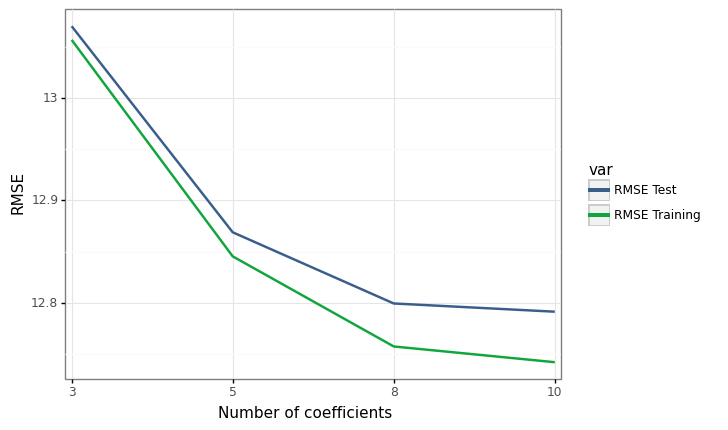

<ggplot: (8767632455699)>

In [34]:
p1

Export .png file

In [35]:
ggsave(plot = p1, filename="Figure1.png", path = "../Output/")

***Reference code***

*Link:*
*https://github.com/gabors-data-analysis/da_case_studies/blob/master/ch09-gender-age-earnings/ch09-earnings-inference.ipynb*
*https://github.com/gabors-data-analysis/da_case_studies/blob/master/ch14-used-cars-log/ch14-used-cars-log.ipynb*
*https://github.com/gabors-data-analysis/da_case_studies/blob/master/ch14-airbnb-reg/ch14-airbnb-prediction.ipynb*